In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'

# TH,TC prepare

In [3]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
print("treeH:",treeH.min(),treeH.max())
th0_10=np.copy(treeH)
th0_10[th0_10==0]=np.nan
th0_10[th0_10>10]=np.nan
th0_10[th0_10<=10]=1

th10_40=np.copy(treeH)
th10_40[th10_40==0]=np.nan
th10_40[th10_40<=10]=np.nan
th10_40[th10_40>10]=1

treeH: 0.0 37.440773


In [4]:
tc_planet = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]
tc_planet=tc_planet.astype(np.float32)
tc_planet[tc_planet==0]=np.nan
tc_planet[tc_planet>100]=np.nan

tc0_20=np.copy(tc_planet)
tc0_20[tc0_20==0]=np.nan
tc0_20[tc0_20>40]=np.nan
tc0_20[tc0_20<=40]=1

tc20_100=np.copy(tc_planet)
tc20_100[tc20_100==0]=np.nan
tc20_100[tc20_100<=40]=np.nan
tc20_100[tc20_100>40]=1

In [26]:
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

dro=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')[0]
dro[dro==0]=np.nan
#mask area
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp*dro#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

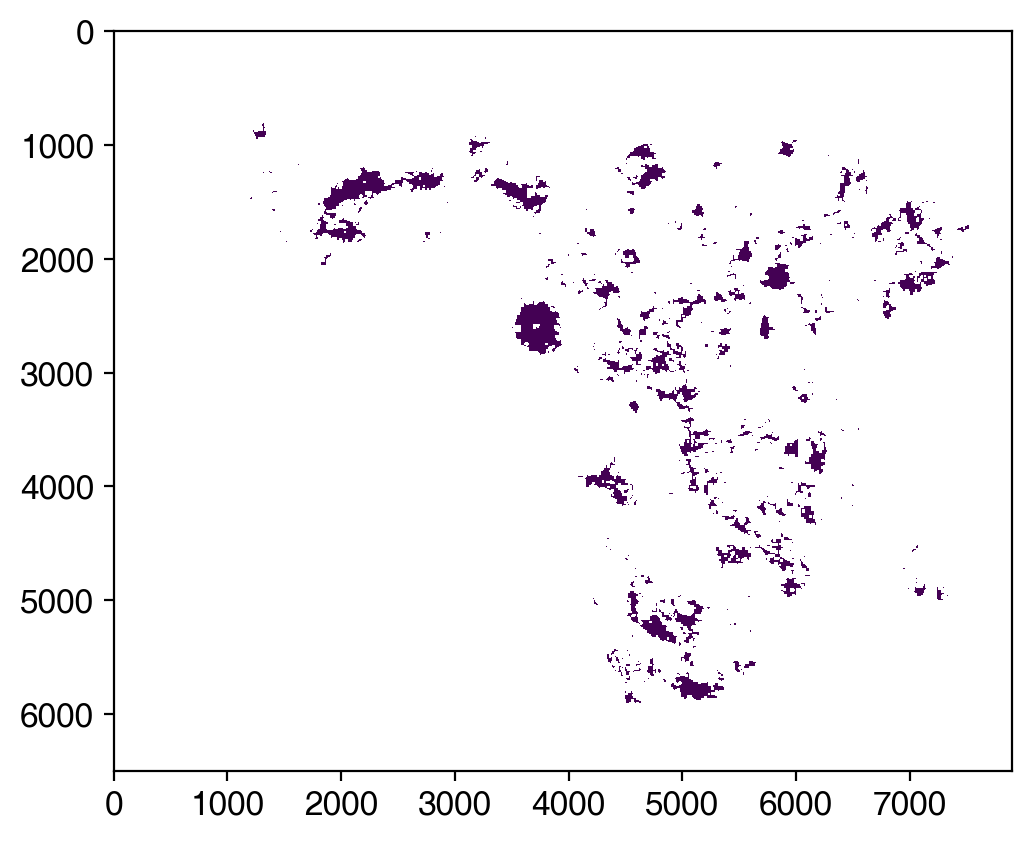

In [25]:
plt.imshow(dro)

# slide_window

In [8]:
"""
2023/11/25
supply paired sites methods.
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                mean_arr[i,j]=np.nan#calculate the mean value
                weight_arr[i,j]=np.nan
    return mean_arr,weight_arr

dist_pool=[th0_10*mask,th10_40*mask,tc0_20*mask,tc20_100*mask]

res_pool=[ndvi_res,csif_res] #protect need conver to fraction
dist_name=['th0_10','th10_40','tc0_20','tc20_100']
res_name=['ndvi_res','csif_res']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(4):
    for j in range(2):
        el=[25,dist_pool[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Small-large-tree_{}_{}_0.25deg_240504.npy'.format(dist_name[i],res_name[j]))
aa_name

['Small-large-tree_th0_10_ndvi_res_0.25deg_240504.npy',
 'Small-large-tree_th0_10_csif_res_0.25deg_240504.npy',
 'Small-large-tree_th10_40_ndvi_res_0.25deg_240504.npy',
 'Small-large-tree_th10_40_csif_res_0.25deg_240504.npy',
 'Small-large-tree_tc0_20_ndvi_res_0.25deg_240504.npy',
 'Small-large-tree_tc0_20_csif_res_0.25deg_240504.npy',
 'Small-large-tree_tc20_100_ndvi_res_0.25deg_240504.npy',
 'Small-large-tree_tc20_100_csif_res_0.25deg_240504.npy']

In [9]:
for i in range(8):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (24520)...
执行任务1 (24520)...
执行任务2 (24520)...
执行任务3 (24520)...
执行任务4 (24520)...
执行任务5 (24520)...
执行任务6 (24520)...
执行任务7 (24520)...


## 成对样点求的了Δ

In [2]:
def kill_nan(dt):
    a=[]
    for i in dt:
        if not np.isnan(i):
            a.append(i)
    return a
dist_name=['th0_10','th10_40','tc0_20','tc20_100']
ndvi_rst=[]
csif_rst=[]
w_ndvi_rst=[]
w_csif_rst=[]
for i in range(4):
    ndvi_rst.append(np.load(drv_path+"Small-large-tree_{}_ndvi_res_0.25deg_240504.npy".format(dist_name[i]))[0])
    csif_rst.append(np.load(drv_path+'Small-large-tree_{}_csif_res_0.25deg_240504.npy'.format(dist_name[i]))[0])
    w_ndvi_rst.append(np.load(drv_path+"Small-large-tree_{}_ndvi_res_0.25deg_240504.npy".format(dist_name[i]))[1])
    w_csif_rst.append(np.load(drv_path+'Small-large-tree_{}_csif_res_0.25deg_240504.npy'.format(dist_name[i]))[1])

In [3]:
TH_ndvi_rst_0_10=kill_nan(ndvi_rst[0].ravel())
TH_ndvi_rst_10_40=kill_nan(ndvi_rst[1].ravel())
TH_csif_rst_0_10=kill_nan(csif_rst[0].ravel())
TH_csif_rst_10_40=kill_nan(csif_rst[1].ravel())

TH_w_ndvi_rst_0_10=kill_nan(w_ndvi_rst[0].ravel())
TH_w_ndvi_rst_10_40=kill_nan(w_ndvi_rst[1].ravel())
TH_w_csif_rst_0_10=kill_nan(w_csif_rst[0].ravel())
TH_w_csif_rst_10_40=kill_nan(w_csif_rst[1].ravel())

#计算加权均值
TH_mean_ndvi_small=np.sum(np.array(TH_ndvi_rst_0_10)*np.array(TH_w_ndvi_rst_0_10))/np.sum(TH_w_ndvi_rst_0_10)
TH_mean_ndvi_large=np.sum(np.array(TH_ndvi_rst_10_40)*np.array(TH_w_ndvi_rst_10_40))/np.sum(TH_w_ndvi_rst_10_40)
TH_mean_csif_small=np.sum(np.array(TH_csif_rst_0_10)*np.array(TH_w_csif_rst_0_10))/np.sum(TH_w_csif_rst_0_10)
TH_mean_csif_large=np.sum(np.array(TH_csif_rst_10_40)*np.array(TH_w_csif_rst_10_40))/np.sum(TH_w_csif_rst_10_40)
print(TH_mean_ndvi_small,TH_mean_ndvi_large,TH_mean_csif_small,TH_mean_csif_large)

0.9828914767647483 1.0123932181855384 0.9587725866577881 0.9855111676606919


In [4]:
TC_ndvi_rst_0_10=kill_nan(ndvi_rst[2].ravel())
TC_ndvi_rst_10_40=kill_nan(ndvi_rst[3].ravel())
TC_csif_rst_0_10=kill_nan(csif_rst[2].ravel())
TC_csif_rst_10_40=kill_nan(csif_rst[3].ravel())

TC_w_ndvi_rst_0_10=kill_nan(w_ndvi_rst[2].ravel())
TC_w_ndvi_rst_10_40=kill_nan(w_ndvi_rst[3].ravel())
TC_w_csif_rst_0_10=kill_nan(w_csif_rst[2].ravel())
TC_w_csif_rst_10_40=kill_nan(w_csif_rst[3].ravel())

#计算加权均值
TC_mean_ndvi_small=np.sum(np.array(TC_ndvi_rst_0_10)*np.array(TC_w_ndvi_rst_0_10))/np.sum(TC_w_ndvi_rst_0_10)
TC_mean_ndvi_large=np.sum(np.array(TC_ndvi_rst_10_40)*np.array(TC_w_ndvi_rst_10_40))/np.sum(TC_w_ndvi_rst_10_40)
TC_mean_csif_small=np.sum(np.array(TC_csif_rst_0_10)*np.array(TC_w_csif_rst_0_10))/np.sum(TC_w_csif_rst_0_10)
TC_mean_csif_large=np.sum(np.array(TC_csif_rst_10_40)*np.array(TC_w_csif_rst_10_40))/np.sum(TC_w_csif_rst_10_40)
print(TC_mean_ndvi_small,TC_mean_ndvi_large,TC_mean_csif_small,TC_mean_csif_large)

0.9747147288378756 1.005832118531993 0.9373012142077565 0.9810669762542965


In [5]:
len(TC_ndvi_rst_0_10),len(TC_ndvi_rst_10_40),len(TC_csif_rst_0_10),len(TC_csif_rst_10_40)

(6548, 4714, 6446, 4709)

In [6]:
len(TH_ndvi_rst_0_10),len(TH_ndvi_rst_10_40),len(TH_csif_rst_0_10),len(TH_csif_rst_10_40)

(5673, 2990, 5648, 2989)

In [7]:
sta,p=stats.mannwhitneyu(TH_ndvi_rst_0_10,TH_ndvi_rst_10_40)
sta1,p1=stats.mannwhitneyu(TH_csif_rst_0_10,TH_csif_rst_10_40)
print(p,p1)

2.0350978562218717e-167 2.5295860586650597e-43


In [8]:
sta,p=stats.mannwhitneyu(TC_ndvi_rst_0_10,TC_ndvi_rst_10_40)
sta1,p1=stats.mannwhitneyu(TC_csif_rst_0_10,TC_csif_rst_10_40)
print(p,p1)

4.7235723519131884e-154 1.0870460749019058e-78


## Fig

In [9]:
data=[TH_ndvi_rst_0_10,TH_ndvi_rst_10_40,TH_csif_rst_0_10,TH_csif_rst_10_40,
      TC_ndvi_rst_0_10,TC_ndvi_rst_10_40,TC_csif_rst_0_10,TC_csif_rst_10_40]
#计算标准误方法1
se1=[]
for i in range(8):
    se1.append(np.std(data[i])/np.sqrt(len(data[i])))
se1

[0.0005201545771155402,
 0.0005529921089161572,
 0.0011007140436744692,
 0.0005142627980123249,
 0.0005664576742987243,
 0.0005206533105074712,
 0.0016211876763647338,
 0.0007837733209451206]

In [10]:
np.mean(TC_ndvi_rst_0_10)

0.9778600302078262

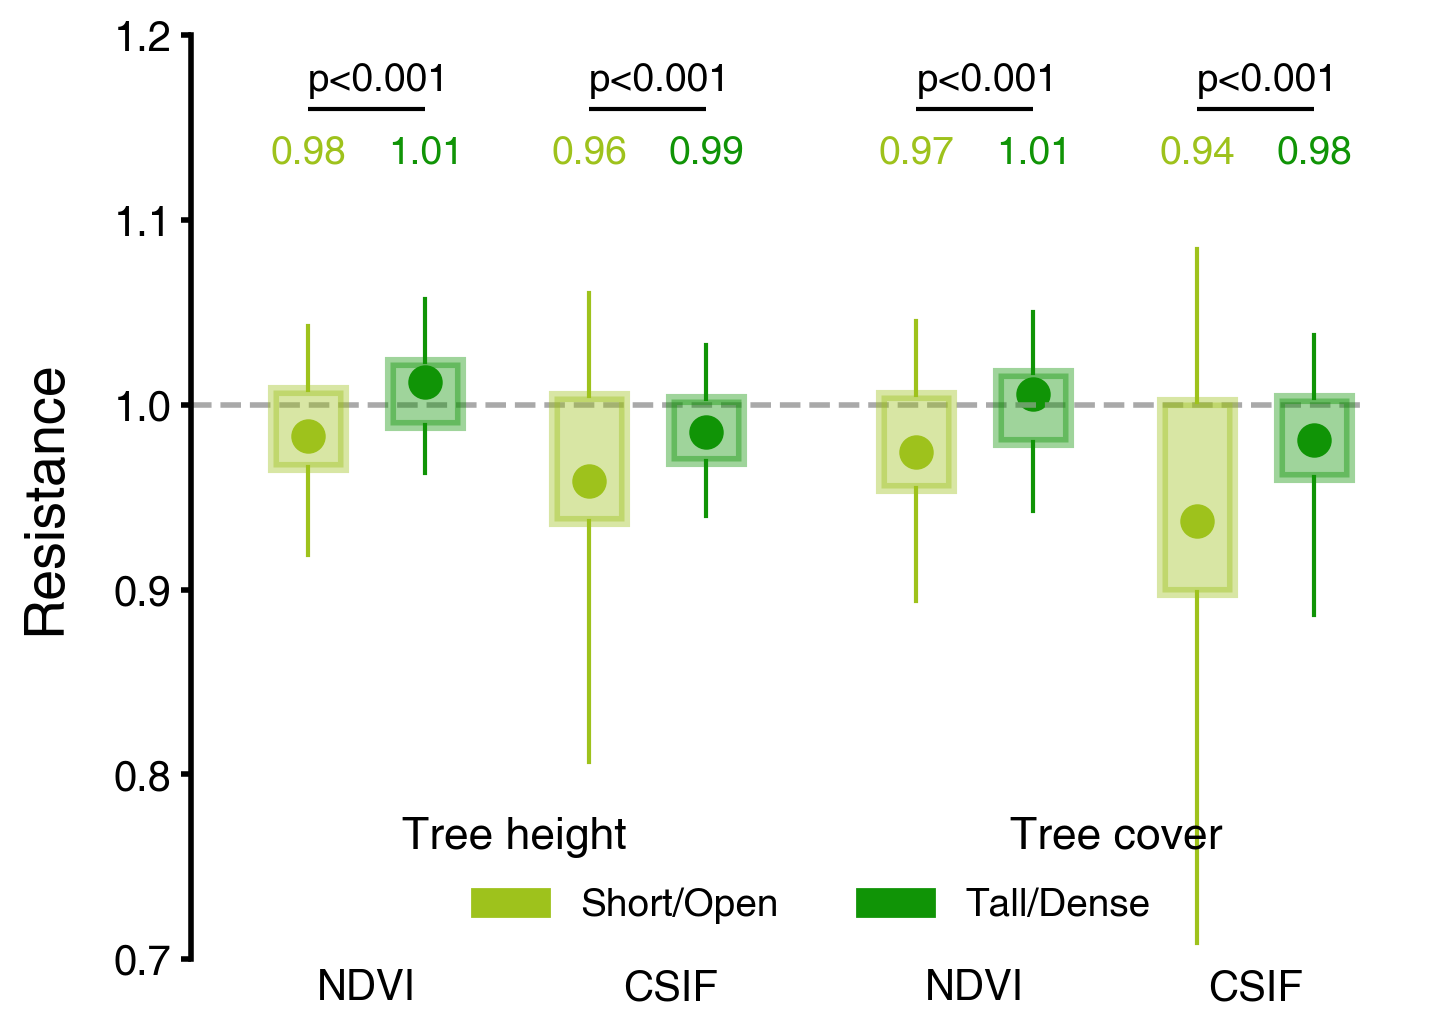

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl1 = np.array([121,201,178])
cl2 = np.array([225,195,121])
cl3 = np.array([248,159,150])
cl4 = np.array([95,158,201])
cl5 = np.array([168,217,234])
cl=[cl1/255,cl2/255,cl3/255,cl4/255,cl5/255]
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label=['TH','TC','NDVI','AGB']
ps=[[1],[1.5],[2.2],[2.7],[3.6],[4.1],[4.8],[5.3]]

data=[TH_ndvi_rst_0_10,TH_ndvi_rst_10_40,TH_csif_rst_0_10,TH_csif_rst_10_40,
      TC_ndvi_rst_0_10,TC_ndvi_rst_10_40,TC_csif_rst_0_10,TC_csif_rst_10_40]
mean=[TH_mean_ndvi_small,TH_mean_ndvi_large,TH_mean_csif_small,TH_mean_csif_large,
      TC_mean_ndvi_small,TC_mean_ndvi_large,TC_mean_csif_small,TC_mean_csif_large]
cl1 = np.array([158,194,28])
cl2 = np.array([16,148,6])
cl=[cl1/255,cl2/255,cl1/255,cl2/255,cl1/255,cl2/255,cl1/255,cl2/255,]
x=[1.25,2.55,3.85,5.05]
x1=[1,1.5,2.2,2.7,3.6,4.1,4.8,5.3]

for i in range(8):
    bplot=ax.boxplot(data[i],
                  vert=True,
                  whis=(5,95),                
                  widths=0.3,
                  patch_artist=True,
                  showmeans=False,
                  meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                  medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                  boxprops={"facecolor": cl[i], "edgecolor": cl[i],"linewidth":4,"alpha":0.4},
                  capprops=None,
                  whiskerprops={'linewidth':'1.5','color':cl[i]},
                  showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                  showfliers = False,
                  flierprops = {'marker':'+','markersize':'4','color':'grey'},
                  positions=ps[i])

    patch=mpatches.Patch(color=cl[i],label='Short')
    ax.scatter(x1[i],mean[i],color=cl[i],s=130)
    ax.text(x1[i]-0.16,1.13, '{:.2f}'.format(mean[i]),color=cl[i],fontsize=14)
    if i==1 or i==5 :
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'NDVI',color='black',fontsize=14)
    if  i==3:
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'CSIF',color='black',fontsize=14)
    if i==7:
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'CSIF',color='black',fontsize=14)

x2=[1.4,4.0]
labels = ['NDVI', 'CSIF','NDVI', 'CSIF']
#lab=['short','tall','short','tall']
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks(x,labels=labels,rotation=0)
ax.xaxis.set_tick_params(labelsize=15,pad=0)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(bottom=False,top=False, left=True, right=False)#隐藏刻度线

ax.text(x2[0],0.76, 'Tree height',color='black',fontsize=16)
ax.text(x2[1],0.76, 'Tree cover',color='black',fontsize=16)
ax.hlines(1,0.5,5.5,lw=2,ls='--',color='darkgray',zorder=1)
blue_patch=mpatches.Patch(color=cl[0],label='Short/Open')
red_patch=mpatches.Patch(color=cl[1],label='Tall/Dense')
ax.legend(handles=[blue_patch,red_patch],ncol=2,fontsize=14,frameon=False,loc='lower center')

ax.set_ylabel('Resistance',size=20,labelpad=15)
ax.set_ylim(0.70,1.2)
ax.set_yticks(np.arange(0.7,1.21,0.1))

ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)

# growth reduction area

## prepare data

In [50]:
treeH = read_img(spei_path+'African_th2019_001_230525.tif')[0]
print("treeH:",treeH.min(),treeH.max())
th0_10=np.copy(treeH)
th0_10[th0_10==0]=np.nan
th0_10[th0_10>10]=np.nan
th0_10[th0_10<=10]=1

th10_40=np.copy(treeH)
th10_40[th10_40==0]=np.nan
th10_40[th10_40<=10]=np.nan
th10_40[th10_40>10]=1

tc_planet = read_img(spei_path+'Africa_tc2019_mosaic_001_fillNaN_231215.tif')[0]
tc_planet=tc_planet.astype(np.float32)
tc_planet[tc_planet==0]=np.nan
tc_planet[tc_planet>100]=np.nan

tc0_20=np.copy(tc_planet)
tc0_20[tc0_20==0]=np.nan
tc0_20[tc0_20>40]=np.nan
tc0_20[tc0_20<=40]=1

tc20_100=np.copy(tc_planet)
tc20_100[tc20_100==0]=np.nan
tc20_100[tc20_100<=40]=np.nan
tc20_100[tc20_100>40]=1

treeH: 0.0 37.440773


In [51]:
ndvi_res=read_img(spei_path+'ndvi_resistance_230321.tif')[0]
csif_res=read_img(spei_path+'csif_resistance_230321.tif')[0]
ndvi_res[ndvi_res==0]=np.nan
csif_res[csif_res==0]=np.nan

DEAA=read_img(spei_path+'SPEI_deaa001_240504.tif')[0]
DAA=read_img(spei_path+'SPEI_daa001_240504.tif')[0]
DEAA[DEAA==0]=np.nan
DAA[DAA==0]=np.nan
#mask area
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#*dro#*forest_mask
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

## slide window

In [52]:
"""
2023/11/25
supply paired sites methods.
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
            else:
                mean_arr[i,j]=np.nan#calculate the mean value
                weight_arr[i,j]=np.nan
    return mean_arr,weight_arr

dist_pool1=[th0_10*mask*DAA,th10_40*mask*DAA,tc0_20*mask*DAA,tc20_100*mask*DAA]
dist_pool2=[th0_10*mask*DEAA,th10_40*mask*DEAA,tc0_20*mask*DEAA,tc20_100*mask*DEAA]

res_pool=[ndvi_res,csif_res] #protect need conver to fraction
dist_name1=['th0_10_daa','th10_40_daa','tc0_20_daa','tc20_100_daa']
dist_name2=['th0_10_deaa','th10_40_deaa','tc0_20_deaa','tc20_100_deaa']
res_name=['ndvi_res','csif_res']
# protect 最后直接加上去
aa=[]
aa_name=[]
for i in range(4):
    for j in range(2):
        el=[25,dist_pool1[i],res_pool[j]]
        aa.append(el)
        aa_name.append('Small-large-tree_{}_{}_0.25deg_240612.npy'.format(dist_name1[i],res_name[j]))
        el2=[25,dist_pool2[i],res_pool[j]]
        aa.append(el2)
        aa_name.append('Small-large-tree_{}_{}_0.25deg_240612.npy'.format(dist_name2[i],res_name[j]))
aa_name

['Small-large-tree_th0_10_daa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_th0_10_deaa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_th0_10_daa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_th0_10_deaa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_th10_40_daa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_th10_40_deaa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_th10_40_daa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_th10_40_deaa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_tc0_20_daa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_tc0_20_deaa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_tc0_20_daa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_tc0_20_deaa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_tc20_100_daa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_tc20_100_deaa_ndvi_res_0.25deg_240612.npy',
 'Small-large-tree_tc20_100_daa_csif_res_0.25deg_240612.npy',
 'Small-large-tree_tc20_100_deaa_csif_res_0.25deg_240612.npy']

In [8]:
len(aa_name)

16

In [9]:
for i in range(16):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(drv_path+aa_name[i],kk)

执行任务0 (69252)...
执行任务1 (69252)...
执行任务2 (69252)...
执行任务3 (69252)...
执行任务4 (69252)...
执行任务5 (69252)...
执行任务6 (69252)...
执行任务7 (69252)...
执行任务8 (69252)...
执行任务9 (69252)...
执行任务10 (69252)...
执行任务11 (69252)...
执行任务12 (69252)...
执行任务13 (69252)...
执行任务14 (69252)...
执行任务15 (69252)...


## 成对样点求Δ

In [53]:
'''
def kill_nan(dt):
    a=[]
    for i in dt:
        if not np.isnan(i):
            a.append(i)
    return a
'''
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a
dist_name1=['th0_10_daa','th10_40_daa','tc0_20_daa','tc20_100_daa']
dist_name2=['th0_10_deaa','th10_40_deaa','tc0_20_deaa','tc20_100_deaa']
ndvi_rst=[]
csif_rst=[]
w_ndvi_rst=[]
w_csif_rst=[]
for i in range(4):
    ndvi_rst.append(np.load(drv_path+"Small-large-tree_{}_ndvi_res_0.25deg_240612.npy".format(dist_name2[i]))[0])
    csif_rst.append(np.load(drv_path+'Small-large-tree_{}_csif_res_0.25deg_240612.npy'.format(dist_name2[i]))[0])
    w_ndvi_rst.append(np.load(drv_path+"Small-large-tree_{}_ndvi_res_0.25deg_240612.npy".format(dist_name2[i]))[1])
    w_csif_rst.append(np.load(drv_path+'Small-large-tree_{}_csif_res_0.25deg_240612.npy'.format(dist_name2[i]))[1])

### daa data

In [54]:
mm_ndvi=[]
mm_sif=[]
for i in range(4):
    tt_ndvi=np.copy(ndvi_rst[i])
    tt_ndvi[tt_ndvi>1]=np.nan
    tt_ndvi[tt_ndvi<=1]=1
    mm_ndvi.append(tt_ndvi)
    
    tt_sif=np.copy(csif_rst[i])
    tt_sif[tt_sif>1]=np.nan
    tt_sif[tt_sif<=1]=1
    mm_sif.append(tt_sif)

In [55]:
TH_ndvi_rst_0_10_daa=kill_nan(ndvi_rst[0]*mm_ndvi[0])
TH_ndvi_rst_10_40_daa=kill_nan(ndvi_rst[1]*mm_ndvi[1])
TH_csif_rst_0_10_daa=kill_nan(csif_rst[0]*mm_sif[0])
TH_csif_rst_10_40_daa=kill_nan(csif_rst[1]*mm_sif[1])

TH_w_ndvi_rst_0_10_daa=kill_nan(w_ndvi_rst[0]*mm_ndvi[0])
TH_w_ndvi_rst_10_40_daa=kill_nan(w_ndvi_rst[1]*mm_ndvi[1])
TH_w_csif_rst_0_10_daa=kill_nan(w_csif_rst[0]*mm_sif[0])
TH_w_csif_rst_10_40_daa=kill_nan(w_csif_rst[1]*mm_sif[1])

#计算加权均值
TH_mean_ndvi_small_daa=np.sum(np.array(TH_ndvi_rst_0_10_daa)*np.array(TH_w_ndvi_rst_0_10_daa))/np.sum(TH_w_ndvi_rst_0_10_daa)
TH_mean_ndvi_large_daa=np.sum(np.array(TH_ndvi_rst_10_40_daa)*np.array(TH_w_ndvi_rst_10_40_daa))/np.sum(TH_w_ndvi_rst_10_40_daa)
TH_mean_csif_small_daa=np.sum(np.array(TH_csif_rst_0_10_daa)*np.array(TH_w_csif_rst_0_10_daa))/np.sum(TH_w_csif_rst_0_10_daa)
TH_mean_csif_large_daa=np.sum(np.array(TH_csif_rst_10_40_daa)*np.array(TH_w_csif_rst_10_40_daa))/np.sum(TH_w_csif_rst_10_40_daa)
print(TH_mean_ndvi_small_daa,TH_mean_ndvi_large_daa,TH_mean_csif_small_daa,TH_mean_csif_large_daa)

0.9627502711349858 0.9778237413816135 0.9310407039348212 0.975149041053998


In [56]:
TC_ndvi_rst_0_10_daa=kill_nan(ndvi_rst[2]*mm_ndvi[2])
TC_ndvi_rst_10_40_daa=kill_nan(ndvi_rst[3]*mm_ndvi[3])
TC_csif_rst_0_10_daa=kill_nan(csif_rst[2]*mm_sif[2])
TC_csif_rst_10_40_daa=kill_nan(csif_rst[3]*mm_sif[3])

TC_w_ndvi_rst_0_10_daa=kill_nan(w_ndvi_rst[2]*mm_ndvi[2])
TC_w_ndvi_rst_10_40_daa=kill_nan(w_ndvi_rst[3]*mm_ndvi[3])
TC_w_csif_rst_0_10_daa=kill_nan(w_csif_rst[2]*mm_sif[2])
TC_w_csif_rst_10_40_daa=kill_nan(w_csif_rst[3]*mm_sif[3])

#计算加权均值
TC_mean_ndvi_small_daa=np.sum(np.array(TC_ndvi_rst_0_10_daa)*np.array(TC_w_ndvi_rst_0_10_daa))/np.sum(TC_w_ndvi_rst_0_10_daa)
TC_mean_ndvi_large_daa=np.sum(np.array(TC_ndvi_rst_10_40_daa)*np.array(TC_w_ndvi_rst_10_40_daa))/np.sum(TC_w_ndvi_rst_10_40_daa)
TC_mean_csif_small_daa=np.sum(np.array(TC_csif_rst_0_10_daa)*np.array(TC_w_csif_rst_0_10_daa))/np.sum(TC_w_csif_rst_0_10_daa)
TC_mean_csif_large_daa=np.sum(np.array(TC_csif_rst_10_40_daa)*np.array(TC_w_csif_rst_10_40_daa))/np.sum(TC_w_csif_rst_10_40_daa)
print(TC_mean_ndvi_small_daa,TC_mean_ndvi_large_daa,TC_mean_csif_small_daa,TC_mean_csif_large_daa)

0.9540408092431714 0.9751010378678239 0.910813702594467 0.9692908853183334


In [57]:
len(TC_ndvi_rst_0_10_daa),len(TC_ndvi_rst_10_40_daa),len(TC_csif_rst_0_10_daa),len(TC_csif_rst_10_40_daa)

(816, 621, 874, 942)

In [58]:
len(TH_ndvi_rst_0_10_daa),len(TH_ndvi_rst_10_40_daa),len(TH_csif_rst_0_10_daa),len(TH_csif_rst_10_40_daa)

(869, 349, 936, 644)

In [59]:
sta,p_daa=stats.mannwhitneyu(TH_ndvi_rst_0_10_daa,TH_ndvi_rst_10_40_daa)
sta1,p1_daa=stats.mannwhitneyu(TH_csif_rst_0_10_daa,TH_csif_rst_10_40_daa)
print(p_daa,p1_daa)

4.833976389090537e-19 6.21511015704612e-48


In [60]:
sta,p_daa=stats.mannwhitneyu(TC_ndvi_rst_0_10_daa,TC_ndvi_rst_10_40_daa)
sta1,p1_daa=stats.mannwhitneyu(TC_csif_rst_0_10_daa,TC_csif_rst_10_40_daa)
print(p_daa,p1_daa)

6.29883902351718e-14 3.4488842323197193e-35


In [61]:
data_daa=[TH_ndvi_rst_0_10_daa,TH_ndvi_rst_10_40_daa,TH_csif_rst_0_10_daa,TH_csif_rst_10_40_daa,
      TC_ndvi_rst_0_10_daa,TC_ndvi_rst_10_40_daa,TC_csif_rst_0_10_daa,TC_csif_rst_10_40_daa]
#计算标准误方法1
se1_daa=[]
for i in range(8):
    se1_daa.append(np.std(data_daa[i])/np.sqrt(len(data_daa[i])))
se1_daa

[0.0011592891643318508,
 0.0010345396602874334,
 0.002345976796309574,
 0.0008226304586178986,
 0.0013961490824353983,
 0.0011814527219579471,
 0.00291543427933933,
 0.0016656459374445054]

### deaa_data

In [62]:
TH_ndvi_rst_0_10_deaa=kill_nan(ndvi_rst[0]*mm_ndvi[0])
TH_ndvi_rst_10_40_deaa=kill_nan(ndvi_rst[1]*mm_ndvi[1])
TH_csif_rst_0_10_deaa=kill_nan(csif_rst[0]*mm_sif[0])
TH_csif_rst_10_40_deaa=kill_nan(csif_rst[1]*mm_sif[1])

TH_w_ndvi_rst_0_10_deaa=kill_nan(w_ndvi_rst[0]*mm_ndvi[0])
TH_w_ndvi_rst_10_40_deaa=kill_nan(w_ndvi_rst[1]*mm_ndvi[1])
TH_w_csif_rst_0_10_deaa=kill_nan(w_csif_rst[0]*mm_sif[0])
TH_w_csif_rst_10_40_deaa=kill_nan(w_csif_rst[1]*mm_sif[1])

#计算加权均值
TH_mean_ndvi_small_deaa=np.sum(np.array(TH_ndvi_rst_0_10_deaa)*np.array(TH_w_ndvi_rst_0_10_deaa))/np.sum(TH_w_ndvi_rst_0_10_deaa)
TH_mean_ndvi_large_deaa=np.sum(np.array(TH_ndvi_rst_10_40_deaa)*np.array(TH_w_ndvi_rst_10_40_deaa))/np.sum(TH_w_ndvi_rst_10_40_deaa)
TH_mean_csif_small_deaa=np.sum(np.array(TH_csif_rst_0_10_deaa)*np.array(TH_w_csif_rst_0_10_deaa))/np.sum(TH_w_csif_rst_0_10_deaa)
TH_mean_csif_large_deaa=np.sum(np.array(TH_csif_rst_10_40_deaa)*np.array(TH_w_csif_rst_10_40_deaa))/np.sum(TH_w_csif_rst_10_40_deaa)
print(TH_mean_ndvi_small_deaa,TH_mean_ndvi_large_deaa,TH_mean_csif_small_deaa,TH_mean_csif_large_deaa)

0.9627502711349858 0.9778237413816135 0.9310407039348212 0.975149041053998


In [63]:
TC_ndvi_rst_0_10_deaa=kill_nan(ndvi_rst[2]*mm_ndvi[2])
TC_ndvi_rst_10_40_deaa=kill_nan(ndvi_rst[3]*mm_ndvi[3])
TC_csif_rst_0_10_deaa=kill_nan(csif_rst[2]*mm_sif[2])
TC_csif_rst_10_40_deaa=kill_nan(csif_rst[3]*mm_sif[3])

TC_w_ndvi_rst_0_10_deaa=kill_nan(w_ndvi_rst[2]*mm_ndvi[2])
TC_w_ndvi_rst_10_40_deaa=kill_nan(w_ndvi_rst[3]*mm_ndvi[3])
TC_w_csif_rst_0_10_deaa=kill_nan(w_csif_rst[2]*mm_sif[2])
TC_w_csif_rst_10_40_deaa=kill_nan(w_csif_rst[3]*mm_sif[3])

#计算加权均值
TC_mean_ndvi_small_deaa=np.sum(np.array(TC_ndvi_rst_0_10_deaa)*np.array(TC_w_ndvi_rst_0_10_deaa))/np.sum(TC_w_ndvi_rst_0_10_deaa)
TC_mean_ndvi_large_deaa=np.sum(np.array(TC_ndvi_rst_10_40_deaa)*np.array(TC_w_ndvi_rst_10_40_deaa))/np.sum(TC_w_ndvi_rst_10_40_deaa)
TC_mean_csif_small_deaa=np.sum(np.array(TC_csif_rst_0_10_deaa)*np.array(TC_w_csif_rst_0_10_deaa))/np.sum(TC_w_csif_rst_0_10_deaa)
TC_mean_csif_large_deaa=np.sum(np.array(TC_csif_rst_10_40_deaa)*np.array(TC_w_csif_rst_10_40_deaa))/np.sum(TC_w_csif_rst_10_40_deaa)
print(TC_mean_ndvi_small_deaa,TC_mean_ndvi_large_deaa,TC_mean_csif_small_deaa,TC_mean_csif_large_deaa)

0.9540408092431714 0.9751010378678239 0.910813702594467 0.9692908853183334


In [64]:
len(TC_ndvi_rst_0_10_deaa),len(TC_ndvi_rst_10_40_deaa),len(TC_csif_rst_0_10_deaa),len(TC_csif_rst_10_40_deaa)

(816, 621, 874, 942)

In [65]:
len(TH_ndvi_rst_0_10_deaa),len(TH_ndvi_rst_10_40_deaa),len(TH_csif_rst_0_10_deaa),len(TH_csif_rst_10_40_deaa)

(869, 349, 936, 644)

In [66]:
sta,p=stats.mannwhitneyu(TH_ndvi_rst_0_10_deaa,TH_ndvi_rst_10_40_deaa)
sta1,p1=stats.mannwhitneyu(TH_csif_rst_0_10_deaa,TH_csif_rst_10_40_deaa)
print(p,p1)

4.833976389090537e-19 6.21511015704612e-48


In [67]:
sta,p=stats.mannwhitneyu(TC_ndvi_rst_0_10_deaa,TC_ndvi_rst_10_40_deaa)
sta1,p1=stats.mannwhitneyu(TC_csif_rst_0_10_deaa,TC_csif_rst_10_40_deaa)
print(p,p1)

6.29883902351718e-14 3.4488842323197193e-35


In [68]:
data_deaa=[TH_ndvi_rst_0_10_deaa,TH_ndvi_rst_10_40_deaa,TH_csif_rst_0_10_deaa,TH_csif_rst_10_40_deaa,
      TC_ndvi_rst_0_10_deaa,TC_ndvi_rst_10_40_deaa,TC_csif_rst_0_10_deaa,TC_csif_rst_10_40_deaa]
#计算标准误方法1
se2=[]
for i in range(8):
    se2.append(np.std(data_deaa[i])/np.sqrt(len(data_deaa[i])))
se2

[0.0011592891643318508,
 0.0010345396602874334,
 0.002345976796309574,
 0.0008226304586178986,
 0.0013961490824353983,
 0.0011814527219579471,
 0.00291543427933933,
 0.0016656459374445054]

## Fig

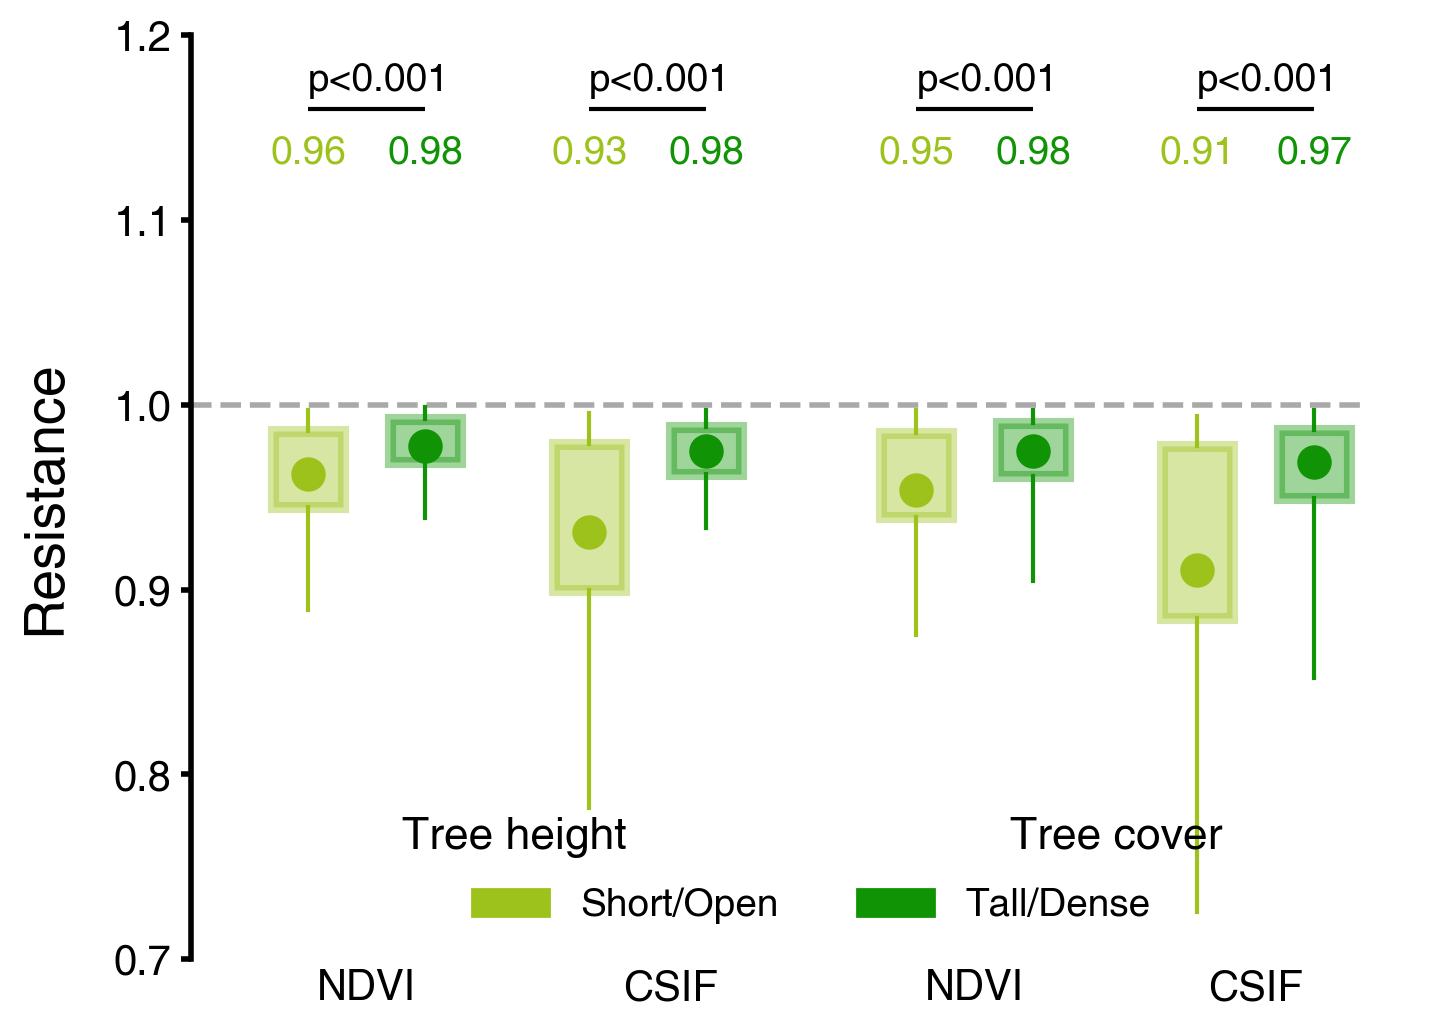

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), sharex=False,sharey=False) ##width, height default(8,6)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)  # pass in the font dict as kwargs

cl1 = np.array([121,201,178])
cl2 = np.array([225,195,121])
cl3 = np.array([248,159,150])
cl4 = np.array([95,158,201])
cl5 = np.array([168,217,234])
cl=[cl1/255,cl2/255,cl3/255,cl4/255,cl5/255]
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
label=['TH','TC','NDVI','AGB']
ps=[[1],[1.5],[2.2],[2.7],[3.6],[4.1],[4.8],[5.3]]

#data=[TH_ndvi_rst_0_10,TH_ndvi_rst_10_40,TH_csif_rst_0_10,TH_csif_rst_10_40,
      #TC_ndvi_rst_0_10,TC_ndvi_rst_10_40,TC_csif_rst_0_10,TC_csif_rst_10_40]
mean=[TH_mean_ndvi_small_daa,TH_mean_ndvi_large_daa,TH_mean_csif_small_daa,TH_mean_csif_large_daa,
      TC_mean_ndvi_small_daa,TC_mean_ndvi_large_daa,TC_mean_csif_small_daa,TC_mean_csif_large_daa]
cl1 = np.array([158,194,28])
cl2 = np.array([16,148,6])
cl=[cl1/255,cl2/255,cl1/255,cl2/255,cl1/255,cl2/255,cl1/255,cl2/255,]
x=[1.25,2.55,3.85,5.05]
x1=[1,1.5,2.2,2.7,3.6,4.1,4.8,5.3]

for i in range(8):
    bplot=ax.boxplot(data_daa[i],
                  vert=True,
                  whis=(5,95),                
                  widths=0.3,
                  patch_artist=True,
                  showmeans=False,
                  meanprops = {'marker':'o','markerfacecolor':cl[i],"markeredgecolor":cl[i],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                  medianprops={'linewidth':'0.5',"color":cl[i],"alpha":0},
                  boxprops={"facecolor": cl[i], "edgecolor": cl[i],"linewidth":4,"alpha":0.4},
                  capprops=None,
                  whiskerprops={'linewidth':'1.5','color':cl[i]},
                  showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                  showfliers = False,
                  flierprops = {'marker':'+','markersize':'4','color':'grey'},
                  positions=ps[i])

    patch=mpatches.Patch(color=cl[i],label='Short')
    ax.scatter(x1[i],mean[i],color=cl[i],s=130)
    ax.text(x1[i]-0.16,1.13, '{:.2f}'.format(mean[i]),color=cl[i],fontsize=14)
    if i==1 or i==5 :
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'NDVI',color='black',fontsize=14)
    if  i==3:
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'CSIF',color='black',fontsize=14)
    if i==7:
        ax.hlines(1.16,x1[i]-0.5,x1[i],colors='black',linewidth=1.5)
        ax.text(x1[i]-0.5,1.17, 'p<0.001',color='black',fontsize=14)
        #ax2.text(x1[i]-0.45,1.18, 'CSIF',color='black',fontsize=14)

x2=[1.4,4.0]
labels = ['NDVI', 'CSIF','NDVI', 'CSIF']
#lab=['short','tall','short','tall']
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks(x,labels=labels,rotation=0)
ax.xaxis.set_tick_params(labelsize=15,pad=0)
ax.yaxis.set_tick_params(labelsize=15)
ax.tick_params(bottom=False,top=False, left=True, right=False)#隐藏刻度线

ax.text(x2[0],0.76, 'Tree height',color='black',fontsize=16)
ax.text(x2[1],0.76, 'Tree cover',color='black',fontsize=16)
ax.hlines(1,0.5,5.5,lw=2,ls='--',color='darkgray',zorder=1)
blue_patch=mpatches.Patch(color=cl[0],label='Short/Open')
red_patch=mpatches.Patch(color=cl[1],label='Tall/Dense')
ax.legend(handles=[blue_patch,red_patch],ncol=2,fontsize=14,frameon=False,loc='lower center')

ax.set_ylabel('Resistance',size=20,labelpad=15)
ax.set_ylim(0.70,1.2)
ax.set_yticks(np.arange(0.7,1.21,0.1))

ax.yaxis.set_tick_params(width=2)
ax.spines['left'].set_linewidth(2)